In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from mlxtend.plotting import plot_decision_regions

In [2]:
df = pd.read_csv("covid_with_dummies.csv")

In [3]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)

In [4]:
df

,death,age_new,USMER_2,SEX_M,PATIENT_TYPE_1,PNEUMONIA_1.0,PREGNANT_1.0,DIABETES_1.0,COPD_1.0,ASTHMA_1.0,INMSUPR_1.0,HIPERTENSION_1.0,OTHER_DISEASE_1.0,CARDIOVASCULAR_1.0,OBESITY_1.0,RENAL_CHRONIC_1.0,TOBACCO_1.0,classification_P
0,1,2,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1
1,1,2,1,1,1,1,0,0,0,0,0,1,0,0,1,1,0,0
2,1,2,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021972,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1021973,0,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1021974,0,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1021975,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.death.value_counts(normalize=True)

0    0.926948
1    0.073052
Name: death, dtype: float64

In [6]:
df.death.value_counts()

0    947320
1     74657
Name: death, dtype: int64

In [7]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score

In [8]:
def scores(y_train,y_val,x_train,x_val,model):
    predicted_train = model.predict(x_train)
    predicted_val = model.predict(x_val)
    precision = [round(precision_score(y_train,predicted_train)*100,2),round(precision_score(y_val,predicted_val)*100,2)]
    recall = [round(recall_score(y_train,predicted_train)*100,2),round(recall_score(y_val,predicted_val)*100,2)]
    f1 = [round(f1_score(y_train,predicted_train)*100,2),round(f1_score(y_val,predicted_val)*100,2)]
    return pd.DataFrame({"Dataset":["Train","Validation"],
                        "Precision": precision,
                        "Recall":recall,
                        "F1 Score":f1,
                        "Accuracy":[round(model.score(x_train, y_train) * 100, 2),round(model.score(x_val, y_val) * 100, 2)]})

In [9]:
def print_confusion_matrix(confusion_matrix, figsize = [12,8], fontsize=12):

    df_cm = pd.DataFrame(confusion_matrix, index=["Alive",'Dead'], columns=["Alive",'Dead'])
    fig = plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    return fig

In [10]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [11]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN().fit_resample(X,y)

In [13]:
Counter(y_adasyn)

Counter({1: 938825, 0: 947320})

In [15]:
X_train, x_test, Y_train, y_test = train_test_split(X_adasyn, y_adasyn,
                                                    test_size = 0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.25, random_state=42)

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
# Logistic Regression
logreg = LogisticRegression(solver='liblinear').fit(x_train, y_train)
adasyn_logreg = scores(y_train,y_val,x_train,x_val,logreg)
adasyn_logreg

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,88.09,89.65,88.86,88.82
1,Validation,88.06,89.59,88.82,88.75


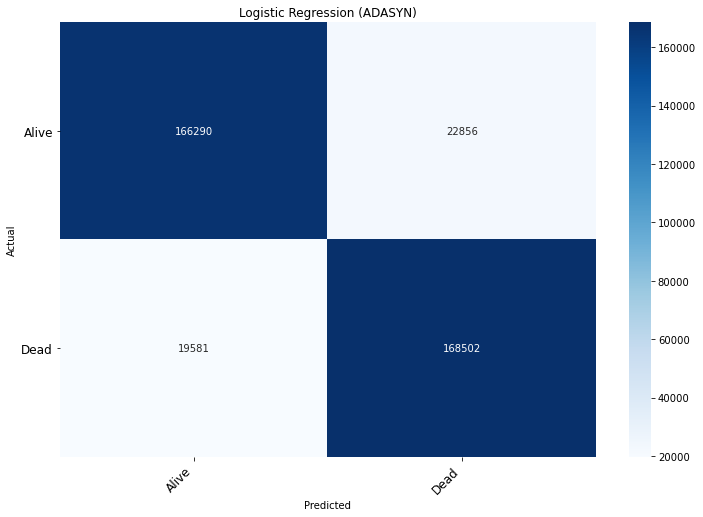

In [20]:
cm = print_confusion_matrix(confusion_matrix(y_val, logreg.predict(x_val)))
plt.title("Logistic Regression (ADASYN)");

In [21]:
# Support Vector classifier
svc = LinearSVC(dual=False).fit(x_train, y_train)
adasyn_svc = scores(y_train,y_val,x_train,x_val,svc)
adasyn_svc

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,87.41,88.27,87.84,87.84
1,Validation,87.34,88.19,87.77,87.74


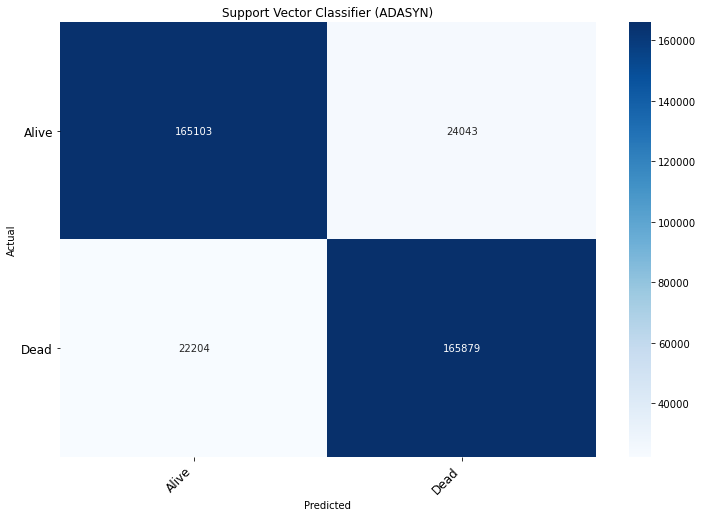

In [22]:
cm = print_confusion_matrix(confusion_matrix(y_val, svc.predict(x_val)))
plt.title("Support Vector Classifier (ADASYN)");

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
# Random forest classifier
random_forest = RandomForestClassifier().fit(x_train, y_train)
adasyn_rf = scores(y_train,y_val,x_train,x_val,random_forest)
adasyn_rf

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,87.57,93.04,90.22,89.97
1,Validation,87.26,92.83,89.96,89.67


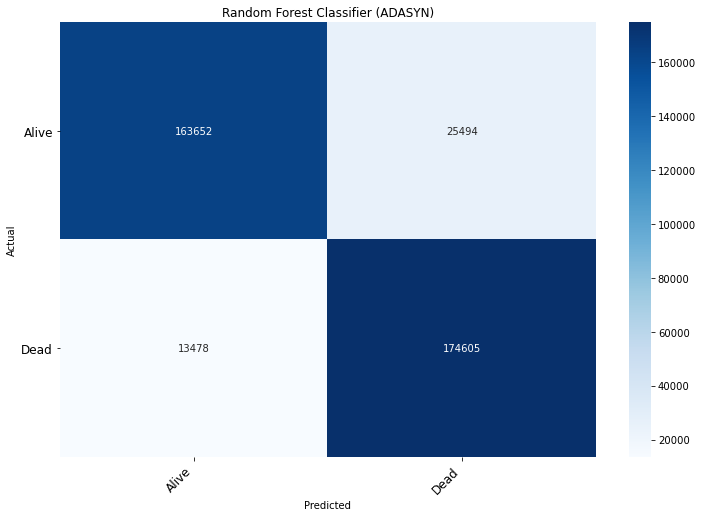

In [25]:
cm = print_confusion_matrix(confusion_matrix(y_val, random_forest.predict(x_val)))
plt.title("Random Forest Classifier (ADASYN)");

In [26]:
# Gaussian Naive Bayes
gaussian = GaussianNB().fit(x_train, y_train)  
adasyn_gaussian = scores(y_train,y_val,x_train,x_val,gaussian)
adasyn_gaussian

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,84.58,86.74,85.65,85.54
1,Validation,84.68,86.66,85.66,85.53


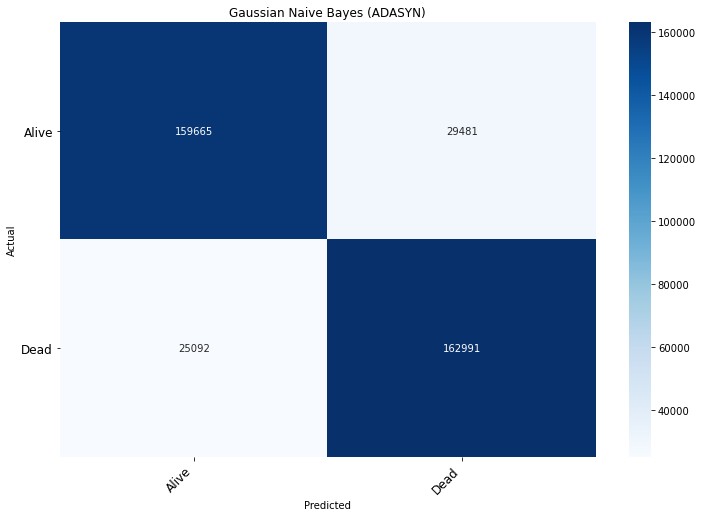

In [27]:
cm = print_confusion_matrix(confusion_matrix(y_val, gaussian.predict(x_val)))
plt.title("Gaussian Naive Bayes (ADASYN)");

In [28]:
from sklearn.linear_model import Perceptron

In [29]:
# Perceptron
perceptron = Perceptron().fit(x_train, y_train)
adasyn_perceptron = scores(y_train,y_val,x_train,x_val,perceptron)
adasyn_perceptron

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,75.43,97.67,85.12,83.02
1,Validation,75.53,97.66,85.18,83.06


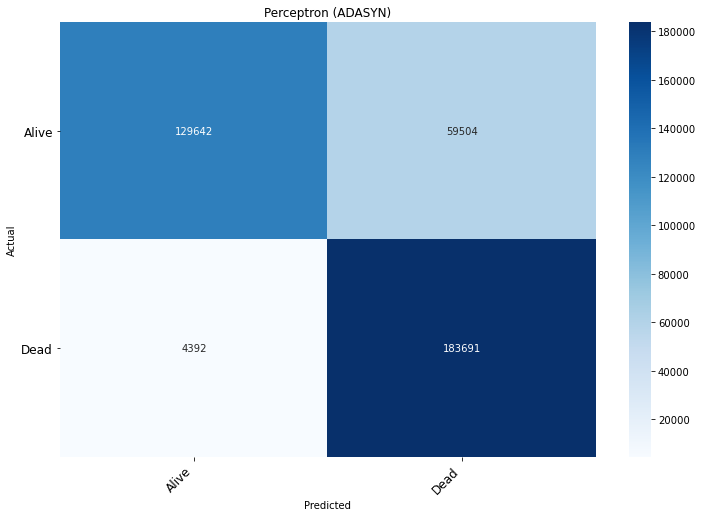

In [30]:
cm = print_confusion_matrix(confusion_matrix(y_val, perceptron.predict(x_val)))
plt.title("Perceptron (ADASYN)");

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
# Decision Tree
decision_tree = DecisionTreeClassifier().fit(x_train, y_train)
adasyn_decision_tree = scores(y_train,y_val,x_train,x_val,decision_tree)
adasyn_decision_tree

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,87.59,93.01,90.22,89.97
1,Validation,87.29,92.76,89.94,89.66


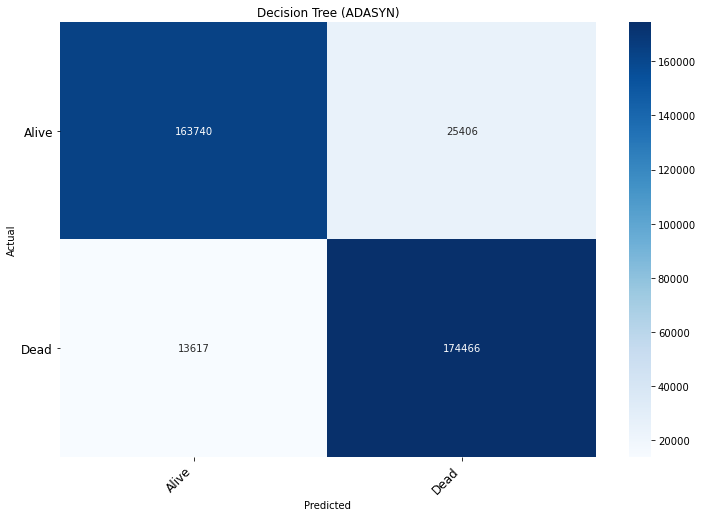

In [33]:
cm = print_confusion_matrix(confusion_matrix(y_val, decision_tree.predict(x_val)))
plt.title("Decision Tree (ADASYN)");

In [34]:
# XGBoost
xgb = XGBClassifier().fit(x_train, y_train)
adasyn_xgb = scores(y_train,y_val,x_train,x_val,xgb)
adasyn_xgb

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,87.09,93.00,89.95,89.66
1,Validation,86.96,92.89,89.83,89.51


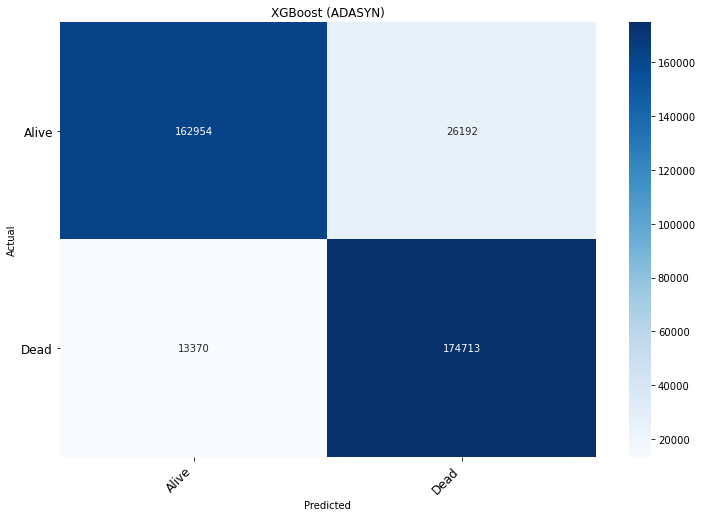

In [35]:
cm = print_confusion_matrix(confusion_matrix(y_val, xgb.predict(x_val)))
plt.title("XGBoost (ADASYN)");

In [37]:
dataframes = [adasyn_logreg,adasyn_svc,adasyn_rf,adasyn_gaussian,adasyn_perceptron,adasyn_decision_tree,adasyn_xgb]
model = ["Logistic Regression","SVC","Random Forest","GaussianNB","Perceptron","Decision Tree","XGBoost"]
precisions = []
recalls = []
f1_scores= []
accuracies = []
for dataframe in dataframes:
    precisions.append(dataframe.iloc[1,1])
    recalls.append(dataframe.iloc[1,2])
    f1_scores.append(dataframe.iloc[1,3])
    accuracies.append(dataframe.iloc[1,4])
models_with_ADASYN = pd.DataFrame({"Model":model, "Precision":precisions,"Recall":recalls,"F1 Score":f1_scores,"Accuracy":accuracies})
models_with_ADASYN.set_index("Model").sort_values(by="F1 Score",ascending=False)

,Precision,Recall,F1 Score,Accuracy
Model,,,,
Random Forest,87.26,92.83,89.96,89.67
Decision Tree,87.29,92.76,89.94,89.66
XGBoost,86.96,92.89,89.83,89.51
Logistic Regression,88.06,89.59,88.82,88.75
SVC,87.34,88.19,87.77,87.74
GaussianNB,84.68,86.66,85.66,85.53
Perceptron,75.53,97.66,85.18,83.06


### <font color="blue"> ADASYN ile veri setimizin dengesini sağladıktan sonra model denemelerimin içinde en iyisi Random Forest. Şimdi Random Forest için cross validation uyguluyorum.

In [38]:
random_forest_last = RandomForestClassifier().fit(X_train, Y_train)

In [39]:
from sklearn.model_selection import cross_val_score

scores_accuracy = cross_val_score(random_forest_last, X_train, Y_train, cv=5, scoring = "accuracy")

print("Scores:", scores_accuracy)
print("Mean:", scores_accuracy.mean())
print("Standard Deviation:", scores_accuracy.std())

Scores: [0.89717811 0.8978405  0.89746275 0.89729044 0.89745612]
Mean: 0.897445583629221
Standard Deviation: 0.00022448869117720446


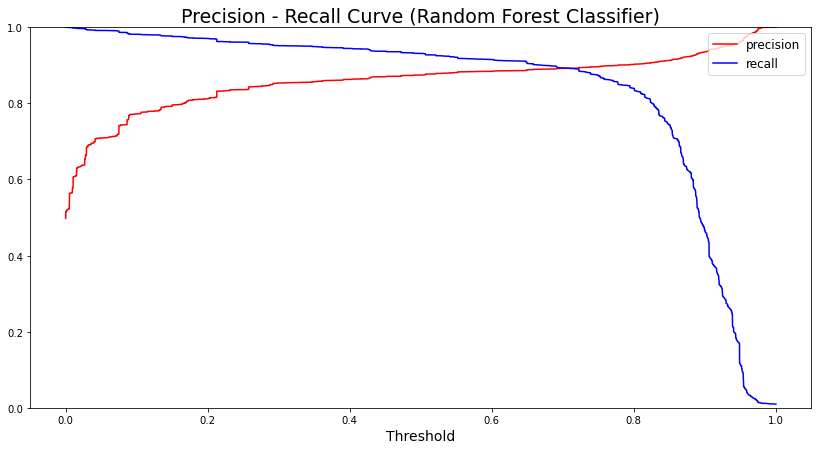

In [40]:
from sklearn.metrics import precision_recall_curve

y_scores = random_forest_last.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision")
    plt.plot(threshold, recall[:-1], "b", label="recall")
    plt.title("Precision - Recall Curve (Random Forest Classifier)",fontsize=19)
    plt.xlabel("Threshold", fontsize=14)
    plt.legend(loc="upper right", fontsize=12)
    plt.ylim([0, 1])

plt.figure(figsize=[14,7])
plot_precision_and_recall(precision, recall, threshold)

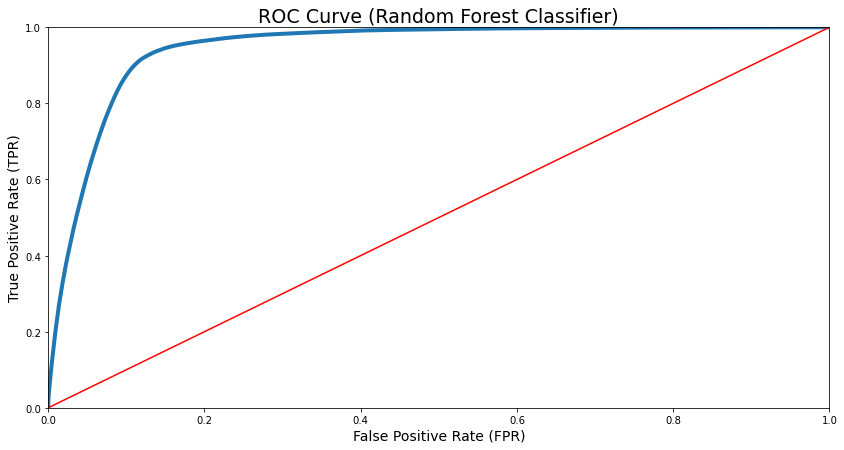

In [41]:
from sklearn.metrics import roc_curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)

def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=4, label=label)
    plt.plot([0, 1], [0, 1], 'r')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC Curve (Random Forest Classifier)",fontsize=19)
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)

plt.figure(figsize=[14,7])
plot_roc_curve(false_positive_rate, true_positive_rate)

In [42]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC Score:", r_a_score)

ROC-AUC Score: 0.9454223533958074


In [43]:
test_pred = random_forest_last.predict(x_test.values)

C:\Users\MERVE\anaconda3\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [44]:
print("Precision:", round(precision_score(y_test,test_pred)*100,2))
print("Recall:", round(recall_score(y_test,test_pred)*100,2))
print("F1 Score:", round(f1_score(y_test,test_pred)*100,2))
print("Accuracy:", round(random_forest_last.score(x_test, y_test) * 100, 2))

Precision: 87.32
Recall: 93.05
F1 Score: 90.09
Accuracy: 89.81


In [45]:
from sklearn.metrics import log_loss

print("Log-Loss: {:2.3f}".format(log_loss(y_test, random_forest_last.predict_proba(x_test))))

Log-Loss: 0.293


In [46]:
from joblib import dump, load

In [47]:
dump(random_forest_last,"random_forest_adasyn.pkl")

['random_forest_adasyn.pkl']